In [1]:
# Import libraries
%matplotlib inline
import pandas as pd
import numpy as np
import os
import glob
import matplotlib as mpl
import seaborn as sns

# Read in raw lines csv
df = pd.read_csv('../data/raw_data/The-Office-Lines-V4.csv')

# Examine dataframe
df.head(3)

,season,episode,title,scene,speaker,line,Unnamed: 6
0,1,1,Pilot,1,Michael,All right Jim. Your quarterlies look very good...,NaN
1,1,1,Pilot,1,Jim,"Oh, I told you. I couldn't close it. So...",NaN
2,1,1,Pilot,1,Michael,So you've come to the master for guidance? Is ...,NaN


In [2]:
# Get information about dataset, including any missing value counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54626 entries, 0 to 54625
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   season      54626 non-null  int64 
 1   episode     54626 non-null  int64 
 2   title       54626 non-null  object
 3   scene       54626 non-null  int64 
 4   speaker     54626 non-null  object
 5   line        54626 non-null  object
 6   Unnamed: 6  17 non-null     object
dtypes: int64(3), object(4)
memory usage: 2.9+ MB


In [3]:
# There are some values in the last column that are non-null, so we'll find these and handle accordingly.
df.loc[df['Unnamed: 6'].notnull()].head(3)

,season,episode,title,scene,speaker,line,Unnamed: 6
3505,2,8,Performance Review,565,Jan,I'm good,how are you?
3645,2,8,Performance Review,578,Jan,I'm heading back to New York,Alan and I will conduct your performance revi...
3666,2,8,Performance Review,579,Michael,Jan is not in a place where she feels she can ...,I'm good. I can go home now.


In [4]:
# The non-null values in this column are the final portions of lines, so change all NaNs in this column to be empty strings
df['Unnamed: 6'] = df['Unnamed: 6'].fillna('')

# Concatenate these extra lines to the lines already in the "line" column in a new column called "extra_lines"
df['full_line'] = df['line'] + df['Unnamed: 6']

# Now we can safely get rid of the old "line" column and the last unnamed column
df.drop(['line', 'Unnamed: 6'], axis=1, inplace=True)

# Rename the resulting column since it now represents each full line
df.rename(columns={'full_line': 'line'}, inplace=True)

# Take a look at resulting cleaned dataframe
df.head(3)

,season,episode,title,scene,speaker,line
0,1,1,Pilot,1,Michael,All right Jim. Your quarterlies look very good...
1,1,1,Pilot,1,Jim,"Oh, I told you. I couldn't close it. So..."
2,1,1,Pilot,1,Michael,So you've come to the master for guidance? Is ...


In [5]:
# We'll want to analyze these lines as they relate to the speaker, so let's make sure the speaker column is clean/consistent
df['speaker'].value_counts()

Michael             10773
Dwight               6752
Jim                  6222
Pam                  4973
Andy                 3698
                    ...  
Fake Stanley            1
Michael and Erin        1
Deliveryman             1
Zion                    1
Carol Stills            1
Name: speaker, Length: 775, dtype: int64

In [6]:
# Preliminarily clean speaker column to prepare to remove misspellings & typos
df['speaker'] = df['speaker'].str.lower()
df['speaker'] = df['speaker'].str.strip()
df['speaker'] = df['speaker'].str.replace('(:)', '', regex=True)
df['speaker'] = df['speaker'].str.replace(r"^ +| +$", r"", regex=True)

In [7]:
# Use difflib to clean data by identifying misspelled speaker names
from difflib import SequenceMatcher

# Create list of all unique speaker names in unprocessed dataframe
unique_names = df['speaker'].unique()

# Manually set threshold to identify names above 75% match
threshold = 0.75
candidate_similar_names = []
name_matches = []
for i, name1 in enumerate(unique_names[:-1]):
    for name2 in unique_names[i+1:]:
        similarity = SequenceMatcher(None, name1, name2).ratio()
        if similarity > threshold:
            candidate_similar_names.append((name1, name2, similarity))
            name_matches.append(name2)

# Print out list of all speaker names with similarity above 75% match
name_matches

['michel',
 'm ichael',
 'micheal',
 'micahel',
 'michae',
 'micael',
 'michal',
 'miichael',
 'mihael',
 'dight',
 'dwight.',
 'joan',
 'm ichael',
 'micheal',
 'micahel',
 'michae',
 'micael',
 'michal',
 'miichael',
 'mihael',
 'phylis',
 'phyliss',
 '"phyllis"',
 'stanely',
 'anglea',
 'angels',
 'angel',
 '"angela"',
 'troy',
 'rory',
 'meridith',
 'delivery boy',
 'darry',
 'daryl',
 'darrly',
 'michael and jim',
 'michael & dwight',
 'michael/dwight',
 'angela and dwight',
 'jim, pam, michael and dwight',
 'michael and erin',
 'michael and andy',
 'co-worker',
 'kathy',
 'other guy at bar',
 'andy and jim',
 'employees',
 'warehouse guy 1',
 'warehouse guy 2',
 'man in line',
 'carroll',
 'carrol',
 'carla',
 'billy',
 'son',
 'andy and michael',
 'dwight, jim and michael',
 'dwight and angela',
 'child',
 'kids',
 "jim's voicemail",
 'michael and erin',
 'michael and andy',
 'waitress',
 'michael and erin',
 'michael and andy',
 'darryl and andy',
 'darryl and kevin',
 'jim & p

In [8]:
# Manually fix as many name misspellings as possible from above list
df['speaker'].replace(['m ichael','micael','micahel','michae','michal','micheal','michel','mihael','miichael'], 'michael', inplace=True)
df['speaker'].replace(['dwight.', 'dight'], 'dwight', inplace=True)
df['speaker'].replace(['dacvid walalce','dacvid wallace', 'david wallcve', 'david'], 'david wallace', inplace=True)
df['speaker'].replace(['deagnelo','denagelo'], 'deangelo', inplace=True)
df['speaker'].replace(['phylis','phyliss', '"phyllis"'], 'phyllis', inplace=True)
df['speaker'].replace(['anglea','angel', 'angels', '"angela"'], 'angela', inplace=True)
df['speaker'].replace(['todd','packer'], 'todd packer', inplace=True)
df['speaker'].replace('all', 'everyone', inplace=True)
df['speaker'].replace(['darrly','darry', 'daryl'], 'darryl', inplace=True)
df['speaker'].replace('stanely', 'stanley', inplace=True)
df['speaker'].replace('meridith', 'meredith', inplace=True)
df['speaker'].replace('holy', 'holly', inplace=True)
df['speaker'].replace('"jim"', 'jim', inplace=True)
df['speaker'].replace('"jo"', 'jo', inplace=True)

# Standardize a speaker's name to include their last name in analysis 
df.loc[((df['speaker'] == "robert") & (df.index > 36998)), "speaker"] = 'robert california'

In [11]:
# Get list of top 30 speakers
top_speakers = df['speaker'].value_counts().head(30).index.tolist()

# Create an "other" category to capture all lines spoken by someone not in the top_speakers list
df.loc[~df["speaker"].isin(top_speakers), "speaker"] = "other"

,season,episode,title,scene,speaker,line
0,1,1,Pilot,1,michael,All right Jim. Your quarterlies look very good...
1,1,1,Pilot,1,jim,"Oh, I told you. I couldn't close it. So..."
2,1,1,Pilot,1,michael,So you've come to the master for guidance? Is ...
3,1,1,Pilot,1,jim,"Actually, you called me in here, but yeah."
4,1,1,Pilot,1,michael,"All right. Well, let me show you how it's done."
...,...,...,...,...,...,...
54621,9,24,Finale,8153,creed,It all seems so very arbitrary. I applied for ...
54622,9,24,Finale,8154,meredith,I just feel lucky that I got a chance to share...
54623,9,24,Finale,8155,phyllis,I'm happy that this was all filmed so I can re...
54624,9,24,Finale,8156,jim,I sold paper at this company for 12 years. My ...


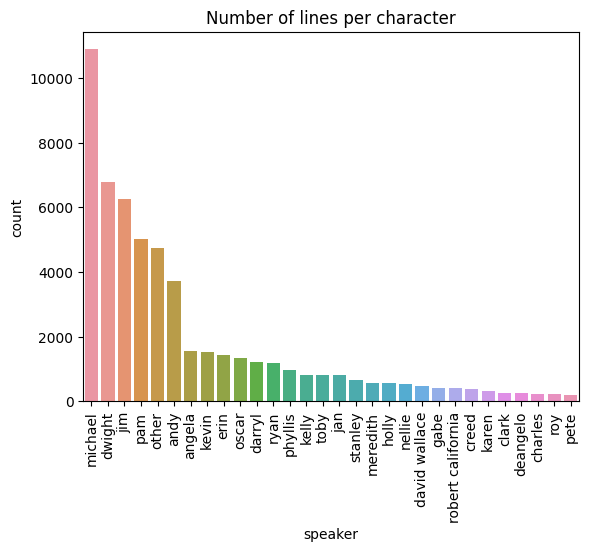

In [35]:
# Plot distribution of speaker lines (for complete show) in descending order
speaker_plt = sns.countplot(df, x="speaker", order=df['speaker'].value_counts().index);

# Set plot title and rotate x-axis labels for readability
speaker_plt.set(title='Number of lines per character');
speaker_plt.set_xticklabels(speaker_plt.get_xticklabels(), rotation=90);

In [33]:
# Number of lines per speaker per season
# df2 = df.groupby(['speaker','season'])[['line']].count().sort_values('line', ascending=False).reset_index()

# Number of scenes per speaker
# df2 = df.groupby(['speaker'])[['scene']].count().sort_values('scene', ascending=False).reset_index()

# Number of lines per speaker
df2 = df.groupby(['speaker'])[['line']].count().sort_values('line', ascending=False).reset_index()

df2

,speaker,line
0,michael,10876
1,dwight,6791
2,jim,6260
3,pam,5005
4,other,4740
5,andy,3733
6,angela,1555
7,kevin,1542
8,erin,1429
9,oscar,1356


In [40]:
# Now, I'll determine the number of total lines in each episode:
total_lines_per_ep = df.groupby(['season', 'episode']).size().reset_index(name="total_lines")
total_lines_per_ep

,season,episode,total_lines
0,1,1,228
1,1,2,203
2,1,3,243
3,1,4,243
4,1,5,230
...,...,...,...
181,9,19,260
182,9,20,233
183,9,21,382
184,9,22,501


In [10]:
# Now, I'll determine the number of lines spoken by each character in each episode:
speaker_lines_per_ep = df2.groupby(['speaker', 'season', 'episode']).size().reset_index(name = "no lines in episode")
lines_per_ep_by_speaker = speaker_lines_per_ep.pivot(index=['season', 'episode'], columns='speaker', values='no lines in episode').fillna(0).reset_index()
lines_per_ep_by_speaker

speaker,season,episode,andy,angela,charles,clark,creed,darryl,david wallace,deangelo,...,oscar,other,pam,pete,phyllis,robert california,roy,ryan,stanley,toby
0,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,4.0,40.0,0.0,2.0,0.0,5.0,8.0,5.0,0.0
1,1,2,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.0,36.0,12.0,0.0,0.0,0.0,0.0,4.0,5.0,2.0
2,1,3,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,4.0,32.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0
3,1,4,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.0,5.0,22.0,0.0,5.0,0.0,3.0,4.0,2.0,4.0
4,1,5,0.0,3.0,0.0,0.0,0.0,15.0,0.0,0.0,...,2.0,18.0,14.0,0.0,4.0,0.0,12.0,8.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,9,19,31.0,2.0,0.0,36.0,2.0,0.0,0.0,0.0,...,7.0,24.0,9.0,2.0,5.0,7.0,0.0,0.0,18.0,14.0
182,9,20,39.0,16.0,0.0,6.0,1.0,10.0,0.0,0.0,...,2.0,38.0,22.0,4.0,0.0,2.0,0.0,0.0,2.0,7.0
183,9,21,68.0,30.0,0.0,8.0,2.0,11.0,37.0,0.0,...,19.0,12.0,30.0,5.0,4.0,0.0,0.0,0.0,4.0,7.0
184,9,22,44.0,39.0,0.0,5.0,4.0,30.0,0.0,0.0,...,28.0,65.0,34.0,4.0,7.0,0.0,0.0,0.0,4.0,0.0


In [11]:
# Merge the two aforementioned dataframes to create a master dataframe with total lines spoken and number of lines spoken by each character in each episode
lines_master_df = pd.merge(total_lines_per_ep, lines_per_ep_by_speaker, on=["season", "episode"], how='outer')
lines_master_df = lines_master_df.astype(int)
lines_master_df

# Uncomment line of code below to write to csv
lines_master_df.to_csv("../data/lines-per-episode.csv")

In [12]:
# Now, I want to explore the number of scenes shared between characters.
# Filter down the dataframe to include only 1 line from each unique speaker in each scene
df3 = df2.drop_duplicates(subset=['season', 'episode', 'scene', 'speaker'])

# Create a dummy matrix with 1's representing a character's presence in a scene 
df3 = pd.get_dummies(df3.set_index(['scene'])['speaker']).max(level=0)
df3

/var/folders/qy/nc2kcrr50vq8wgk5qy78_31w0000gn/T/ipykernel_8804/2165324847.py:6: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  df3 = pd.get_dummies(df3.set_index(['scene'])['speaker']).max(level=0)


,andy,angela,charles,clark,creed,darryl,david wallace,deangelo,dwight,erin,...,oscar,other,pam,pete,phyllis,robert california,roy,ryan,stanley,toby
scene,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8153,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8154,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8155,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [13]:
# Create another dataframe that contains season, episode, title, and scene data
df4 = df2.drop_duplicates(['season', 'episode', 'scene'])
df4 = df4.drop(labels=['speaker', 'line'], axis=1)
df4.reset_index()

# Merge the dummy matrix and scene/episode/season/title dataframes together to ensure this data is not lost
resultdf = pd.merge(df3, df4, on="scene", how='outer')

# Reorder columns to keep data readable and clean
resultdf = resultdf.reindex(columns=['season',
       'episode', 'title', 'scene', 'andy', 'angela', 'charles', 'clark', 'creed', 'darryl',
       'david wallace', 'deangelo', 'dwight', 'erin', 'gabe', 'holly',
       'jan', 'jim', 'jo', 'karen', 'kelly', 'kevin', 'meredith',
       'michael', 'nellie', 'oscar', 'other', 'pam', 'pete', 'phyllis',
       'robert california', 'roy', 'ryan', 'stanley', 'toby'])

resultdf

,season,episode,title,scene,andy,angela,charles,clark,creed,darryl,...,oscar,other,pam,pete,phyllis,robert california,roy,ryan,stanley,toby
0,1,1,Pilot,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,Pilot,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,Pilot,3,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,1,1,Pilot,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,Pilot,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8152,9,24,Finale,8153,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8153,9,24,Finale,8154,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8154,9,24,Finale,8155,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8155,9,24,Finale,8156,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# Create a co-occurrence matrix to determine how many times characters appear in scenes together

# First, drop unnecessary columns and convert entire dataframe to integers
resultdf_asint = resultdf.drop(['scene', 'episode', 'season', 'title'], axis=1)
resultdf_asint = resultdf_asint.astype(int)

# Then, multiply matrix with its transpose to get co-occurrence matrix
co_matrix = resultdf_asint.T.dot(resultdf_asint)

# Fill diagonal with 0s to create true and symmetrical co-occurrence matrix
np.fill_diagonal(co_matrix.values, 0)

# Set option to view entire matrix
pd.set_option('display.max_columns', None)
co_matrix

,andy,angela,charles,clark,creed,darryl,david wallace,deangelo,dwight,erin,gabe,holly,jan,jim,jo,karen,kelly,kevin,meredith,michael,nellie,oscar,other,pam,pete,phyllis,robert california,roy,ryan,stanley,toby
andy,0,133,12,21,54,137,19,14,311,219,37,9,8,286,3,18,78,191,91,211,35,159,256,212,17,169,54,0,70,127,37
angela,133,0,8,8,43,31,1,5,275,60,14,7,14,124,1,15,73,195,82,167,26,187,138,181,7,141,6,4,29,72,39
charles,12,8,0,0,0,0,10,0,23,2,0,0,0,27,0,0,6,8,0,20,0,2,7,13,0,4,0,0,3,5,1
clark,21,8,0,0,3,12,3,0,47,13,0,0,1,15,0,0,0,12,9,0,5,11,23,16,13,10,0,0,0,11,3
creed,54,43,0,3,0,15,3,1,77,28,10,3,3,77,0,3,29,62,44,77,13,54,49,72,6,56,5,0,27,38,25
darryl,137,31,0,12,15,0,0,13,91,37,30,13,1,86,2,2,32,88,33,106,21,64,126,79,6,57,6,15,21,32,29
david wallace,19,1,10,3,3,0,0,0,29,9,0,2,8,27,0,2,3,4,3,65,1,3,25,11,1,7,4,0,6,3,2
deangelo,14,5,0,0,1,13,0,0,9,8,6,0,0,21,1,0,4,14,5,29,0,7,8,12,0,5,0,0,7,6,3
dwight,311,275,23,47,77,91,29,9,0,139,48,26,29,647,9,20,106,188,116,665,80,191,456,368,12,222,24,10,134,161,71
erin,219,60,2,13,28,37,9,8,139,0,33,12,0,107,3,0,41,101,50,116,38,76,119,117,46,81,23,0,39,50,17


In [15]:
co_matrix.to_csv("../data/shared-scenes-matrix.csv")

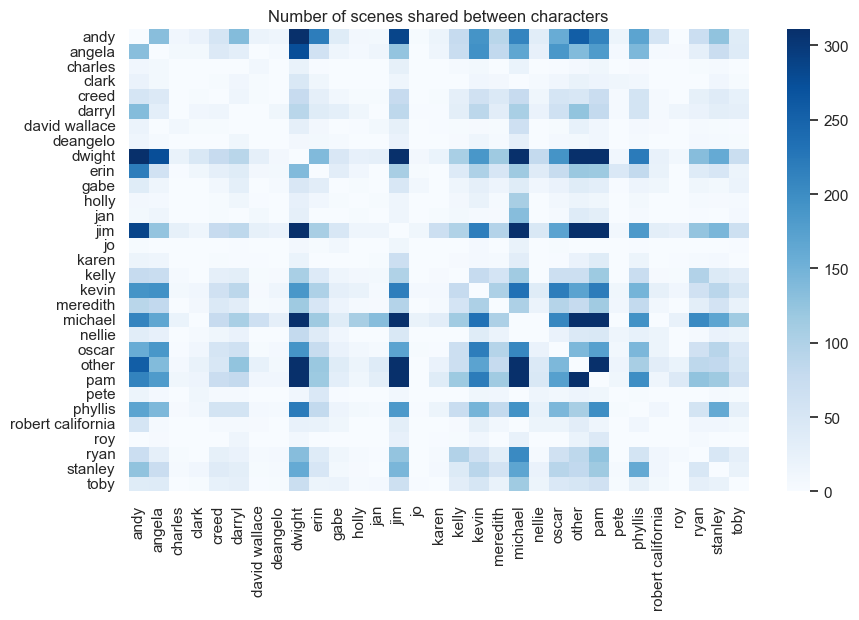

In [16]:
# Now, we can plot this scene co-occurrence as a heatmap using Seaborn 

# Set width and height for clean viewing
sns.set(rc={"figure.figsize":(10, 6)})

coocc_plot = sns.heatmap(co_matrix, robust=True, xticklabels=True, yticklabels=True, cmap="Blues")
coocc_plot.set(title='Number of scenes shared between characters');

In [17]:
# Reshape the dataframe to get each line, in order, by each speaker, categorized by season
df2 = df2.set_index(['season'], append=True)
df3 = df2.pivot(columns='speaker', values='line')
df3.fillna('', inplace=True)
df3 = df3.reset_index()
df3.drop('level_0', axis=1, inplace=True)
df3 = df3.rename_axis(None, axis=1)
df3

,season,andy,angela,charles,clark,creed,darryl,david wallace,deangelo,dwight,erin,gabe,holly,jan,jim,jo,karen,kelly,kevin,meredith,michael,nellie,oscar,other,pam,pete,phyllis,robert california,roy,ryan,stanley,toby
0,1,,,,,,,,,,,,,,,,,,,,All right Jim. Your quarterlies look very good...,,,,,,,,,,,
1,1,,,,,,,,,,,,,,"Oh, I told you. I couldn't close it. So...",,,,,,,,,,,,,,,,,
2,1,,,,,,,,,,,,,,,,,,,,So you've come to the master for guidance? Is ...,,,,,,,,,,,
3,1,,,,,,,,,,,,,,"Actually, you called me in here, but yeah.",,,,,,,,,,,,,,,,,
4,1,,,,,,,,,,,,,,,,,,,,"All right. Well, let me show you how it's done.",,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54621,9,,,,,It all seems so very arbitrary. I applied for ...,,,,,,,,,,,,,,,,,,,,,,,,,,
54622,9,,,,,,,,,,,,,,,,,,,I just feel lucky that I got a chance to share...,,,,,,,,,,,,
54623,9,,,,,,,,,,,,,,,,,,,,,,,,,,I'm happy that this was all filmed so I can re...,,,,,
54624,9,,,,,,,,,,,,,,I sold paper at this company for 12 years. My ...,,,,,,,,,,,,,,,,,


In [18]:
# Make list of speaker names (all columns except 'season' column)
speakers = np.delete(df3.columns.values, 0)
speakers

array(['andy', 'angela', 'charles', 'clark', 'creed', 'darryl',
       'david wallace', 'deangelo', 'dwight', 'erin', 'gabe', 'holly',
       'jan', 'jim', 'jo', 'karen', 'kelly', 'kevin', 'meredith',
       'michael', 'nellie', 'oscar', 'other', 'pam', 'pete', 'phyllis',
       'robert california', 'roy', 'ryan', 'stanley', 'toby'],
      dtype=object)

In [19]:
# Custom function that gets a character's entire dialogue within each season and writes it locally to a text file
def get_character_dialogue_by_szn(name):
    listofdfs=[]
    for season in range(1,10):
        tempdf = df3.loc[df3['season'] == season]
        tempdf = tempdf.filter([name], axis=1)
        listofdfs.append(tempdf)
    for e in range(0,9):
        with open("./data/dialogue for nlp/"+str(name)+"_season_"+ str(e+1) + ".txt", 'a') as f:
            df_string = listofdfs[e].to_string(header=False, index=False)
            f.write(df_string)
            
def get_character_dialogue(name):
        tempdf = df3.filter([name], axis=1)
        with open("./data/dialogue for nlp/"+str(name)+".txt", 'a') as f:
            df_string = tempdf.to_string(header=False, index=False)
            f.write(df_string)


In [20]:
# Run the above function for each speaker (using the list of speakers to loop through) to create local txt files
# for speaker in speakers:
#     get_character_dialogue_by_szn(speaker)
    
for speaker in speakers:
    get_character_dialogue(speaker)

FileNotFoundError: [Errno 2] No such file or directory: './data/dialogue for nlp/andy.txt'